## Part 1: Wrangling

Using SQL compute a relation containing the total payroll and winning percentage (number of wins / number of games * 100) for each team (that is, for each teamID and yearID combination). You should include other columns that will help when performing EDA later on (e.g., franchise ids, number of wins, number of games).

In [42]:
import sqlite3, pandas, numpy as np,seaborn as sns
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

In [2]:
salary_query = """SELECT yearID, teamID, sum(salary) as total_payroll
                    FROM Salaries
                    GROUP BY yearID, teamID
"""

team_salaries = pandas.read_sql(salary_query, conn)

In [3]:
team_salaries

,yearID,teamID,total_payroll
0,1985,ATL,14807000.0
1,1985,BAL,11560712.0
2,1985,BOS,10897560.0
3,1985,CAL,14427894.0
4,1985,CHA,9846178.0
...,...,...,...
855,2014,SLN,120693000.0
856,2014,TBA,72689100.0
857,2014,TEX,112255059.0
858,2014,TOR,109920100.0


In [4]:
teams_query = """SELECT yearID, teamID, W as Wins, G as Games
                    FROM Teams 
                    GROUP BY yearID, teamID"""

team_wins = pandas.read_sql(teams_query, conn)

In [5]:
team_wins

,yearID,teamID,Wins,Games
0,1871,BS1,20,31
1,1871,CH1,19,28
2,1871,CL1,10,29
3,1871,FW1,7,19
4,1871,NY2,16,33
...,...,...,...,...
2770,2014,SLN,90,162
2771,2014,TBA,77,162
2772,2014,TEX,67,162
2773,2014,TOR,83,162


In [6]:
q1_df = pandas.merge(team_salaries, team_wins, how='left', on=['yearID', 'teamID'])
q1_df["winning_percentage"] = (q1_df["Wins"] / q1_df["Games"] *100).round(2)
q1_df.drop(["Wins", "Games"], axis=1, inplace=True)

In [7]:
q1_df

,yearID,teamID,total_payroll,winning_percentage
0,1985,ATL,14807000.0,40.74
1,1985,BAL,11560712.0,51.55
2,1985,BOS,10897560.0,49.69
3,1985,CAL,14427894.0,55.56
4,1985,CHA,9846178.0,52.15
...,...,...,...,...
855,2014,SLN,120693000.0,55.56
856,2014,TBA,72689100.0,47.53
857,2014,TEX,112255059.0,41.36
858,2014,TOR,109920100.0,51.23


## Part 2: Exploratory Data Analysis

### Payroll Distribution

#### Problem 2 (8 pts)

Write code to produce plots that illustrate the distribution of payrolls across teams conditioned on time (from 1990-2014).

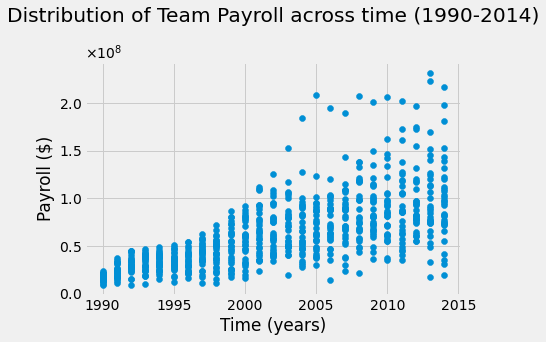

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
xfmt = ScalarFormatter(useMathText = True)
xfmt.set_powerlimits((0,8))
q2_df = q1_df.copy(deep=True)
q2_df = q2_df.loc[(q2_df["yearID"]<=2014) & (q2_df["yearID"]>=1990)]
plt.style.use('fivethirtyeight')

plt.scatter(q2_df["yearID"], q2_df["total_payroll"], label = "all")
plt.title("Distribution of Team Payroll across time (1990-2014)", pad=40)
plt.gca().yaxis.set_major_formatter(xfmt)
plt.xlabel("Time (years)")
plt.ylabel("Payroll ($)")
plt.show()

#### Question 1 (9 pts)

What statements can you make about the distribution of payrolls conditioned on time based on these plots? Remember you can make statements in terms of central tendency, spread, etc.

Mean and median payrolls have increased over time.
The spread of payrolls has increased with time, with the distributions getting more left skewed over time

#### Problem 3 (8 pts)

Write code to produce plots that specifically show at least one of the statements you made in Question 1. For example, if you make a statement that there is a trend for payrolls to decrease over time, make a plot of a statistic for central tendency (e.g., mean payroll) vs. time to show that specficially.

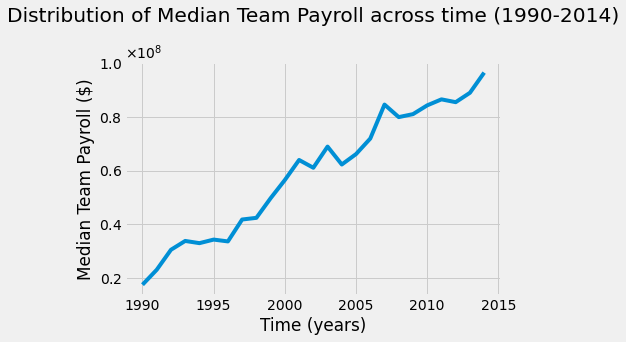

In [9]:
q3_df = q2_df.groupby('yearID', as_index=False).median()

plt.plot(q3_df["yearID"], q3_df["total_payroll"], label = "all")
plt.title("Distribution of Median Team Payroll across time (1990-2014)", pad=40)
plt.style.use('fivethirtyeight')
plt.gca().yaxis.set_major_formatter(xfmt)
plt.xlabel("Time (years)")
plt.ylabel("Median Team Payroll ($)")
plt.show()

#### Problem 4 (8 pts)

Write code to discretize year into five time periods (you can use [pandas.cut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) to accomplish this) and then make a scatterplot showing mean winning percentage (y-axis) vs. mean payroll (x-axis) for each of the five time periods. You could add a regression line (using, e.g., NumPy's [polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html)) in each scatter plot to ease interpretation.


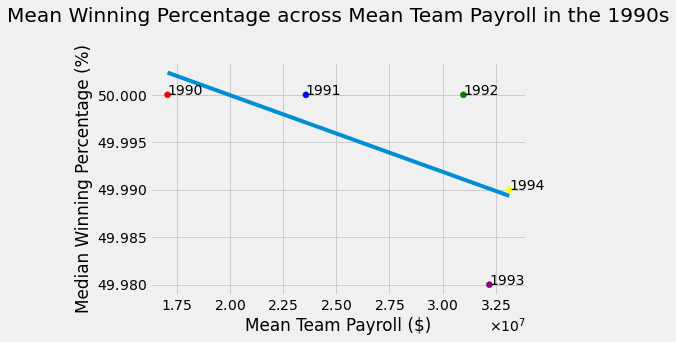

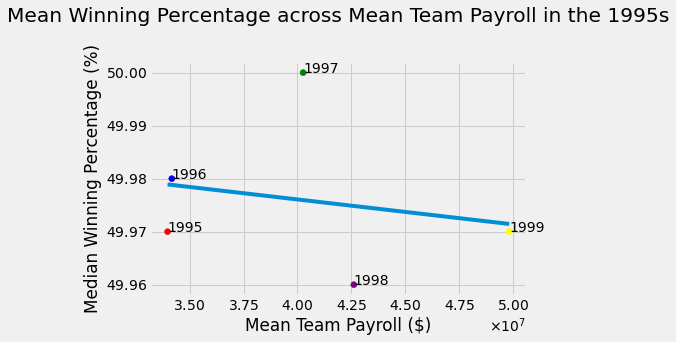

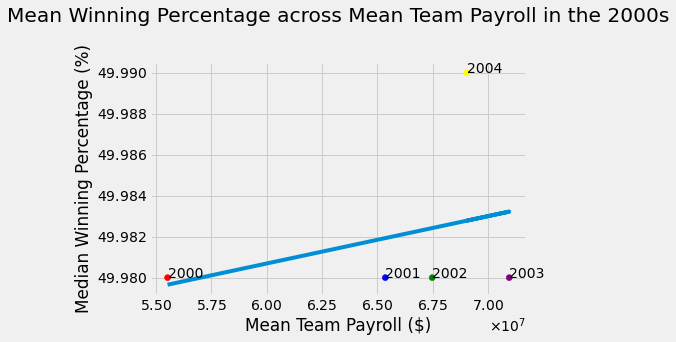

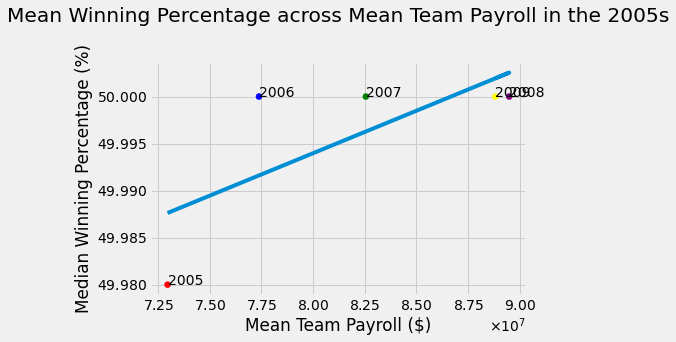

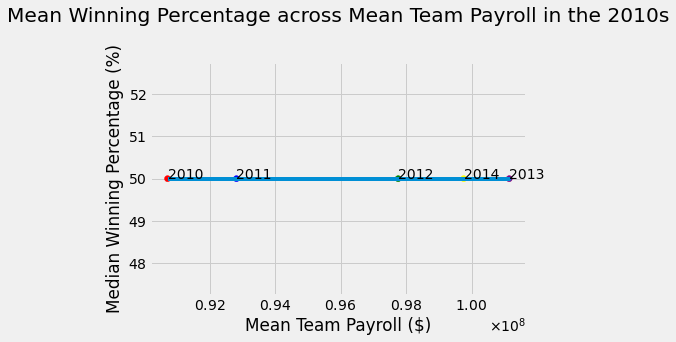

In [16]:
# obtain means
q4_df = q2_df.groupby('yearID', as_index=False).mean()

#round off those pesky decimals
q4_df["winning_percentage"] = q4_df["winning_percentage"].round(2)
q4_df["total_payroll"] = q4_df["total_payroll"].round(2)

# create bins the only way I know how
q4_df["half_decade"] = (q4_df["yearID"] //5 ) * 5
periods = [1990, 1995, 2000, 2005, 2010]

# Axes formatting stuff
xfmt = ScalarFormatter(useMathText = True)
xfmt.set_powerlimits((0,7))
yfmt = ScalarFormatter(useMathText = True, useOffset=False)
colors =['red', 'blue','green','purple','yellow']

for period in periods:
    # get the slice of df for that period
    slice_df = q4_df[q4_df["half_decade"] == period]
   
    # calculate regression coeffs
    m, b = np.polyfit(slice_df["total_payroll"], slice_df["winning_percentage"], 1)

    # plot points
    plt.scatter(slice_df["total_payroll"], slice_df["winning_percentage"], c=colors)
    # plot regression line
    plt.plot(slice_df["total_payroll"], m* slice_df["total_payroll"] +b)

    # Add descriptive texts
    plt.title(f"Mean Winning Percentage across Mean Team Payroll in the {period}s", pad=40)
    plt.gca().xaxis.set_major_formatter(xfmt)
    plt.gca().yaxis.set_major_formatter(yfmt)
    plt.xlabel("Mean Team Payroll ($)")
    plt.ylabel("Mean Winning Percentage (%)")

    # add annotation for each point
    for i, year in enumerate(slice_df["yearID"]):
        plt.annotate(year, (slice_df["total_payroll"].iloc[i], slice_df["winning_percentage"].iloc[i]))
    plt.show()

#### Question 2 (9 pts)

What can you say about team payrolls across these periods? Are there any teams that standout as being particularly good at paying for wins across these time periods? What can you say about the Oakland A's spending efficiency across these time periods (labeling points in the scatterplot can help interpretation).

As Mean Team Payroll increased, Mean Winning Percentage decreased from 1990 -2000.

## Part 3: Data transformations

### Standardizing across years

It looks like comparing payrolls across years is problematic so let's do a transformation that will help with these comparisons.

#### Problem 5 (8 pts)

Create a new variable in your dataset that standardizes payroll conditioned on year. So, this column for team `i` in year `j` should equal:

<!--
```
$ standardized\_payroll_{ij} = \frac{{payroll}_{ij} - \overline{payroll}_{j} }{{s}_{j}} $
```
-->

![](figs/prob5_alternate.png)

for team `i` in year `j`.

where <!--<em><span style="text-decoration: overline">payroll</span><sub>j</sub></em>--> <em>avg\_payroll<sub>j</sub></em> is the average payroll for year `j`, and <em>s<sub>j</sub></em> is the standard deviation of payroll for year `j`.

In [23]:
q5_df = q1_df.copy(deep=True)

# calculate avg_payroll and std_dev_payroll
avg_payroll_df = q1_df.groupby('yearID', as_index=False)["total_payroll"].agg({'average_payroll': 'mean'})
std_dev_payroll_df = q1_df.groupby('yearID', as_index=False)["total_payroll"].agg({'std_dev_payroll': 'std'})

q5_df = q5_df.merge(avg_payroll_df, on="yearID")
q5_df = q5_df.merge(std_dev_payroll_df, on="yearID")

q5_df["standardized_payroll"] =( q5_df["total_payroll"] - q5_df["average_payroll"])/ q5_df["std_dev_payroll"]

q5_df

,yearID,teamID,total_payroll,winning_percentage,average_payroll,std_dev_payroll,standardized_payroll
0,1985,ATL,14807000.0,40.74,1.007557e+07,2.470845e+06,1.914905
1,1985,BAL,11560712.0,51.55,1.007557e+07,2.470845e+06,0.601068
2,1985,BOS,10897560.0,49.69,1.007557e+07,2.470845e+06,0.332678
3,1985,CAL,14427894.0,55.56,1.007557e+07,2.470845e+06,1.761474
4,1985,CHA,9846178.0,52.15,1.007557e+07,2.470845e+06,-0.092838
...,...,...,...,...,...,...,...
855,2014,SLN,120693000.0,55.56,9.975993e+07,4.561922e+07,0.458865
856,2014,TBA,72689100.0,47.53,9.975993e+07,4.561922e+07,-0.593408
857,2014,TEX,112255059.0,41.36,9.975993e+07,4.561922e+07,0.273901
858,2014,TOR,109920100.0,51.23,9.975993e+07,4.561922e+07,0.222717


#### Problem 6 (8 pts)

Repeat the same plots as Problem 4, but use this new standardized payroll variable.

#### Question 3 (9 pts)

Discuss how the plots from Problem 4 and Problem 6 reflect the transformation you did on the payroll variable.


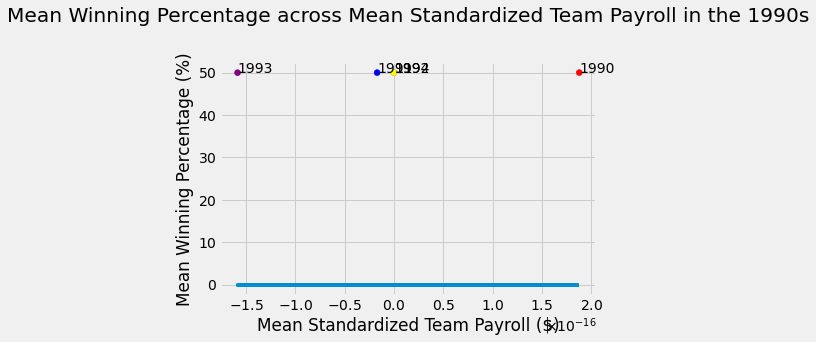

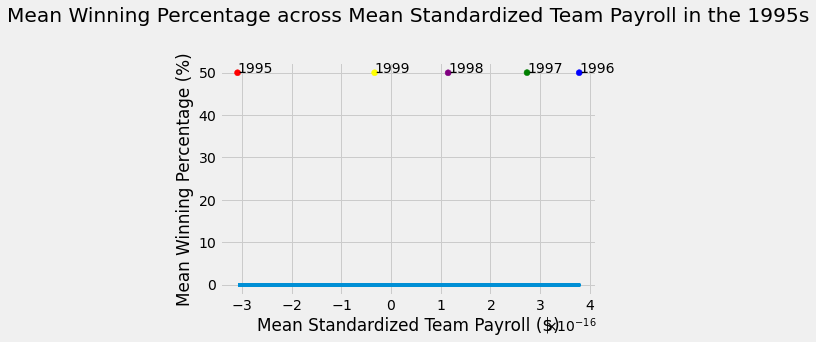

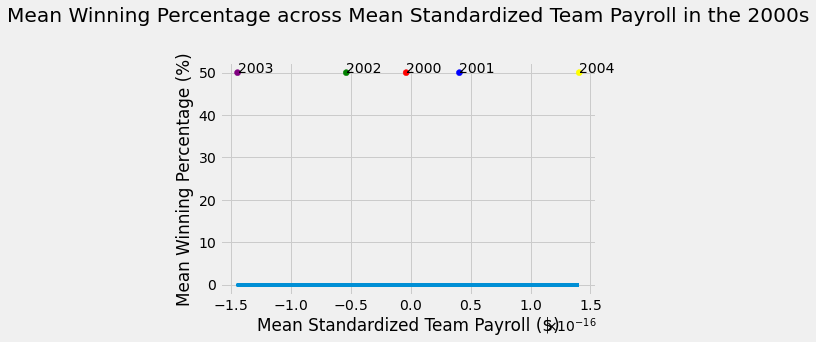

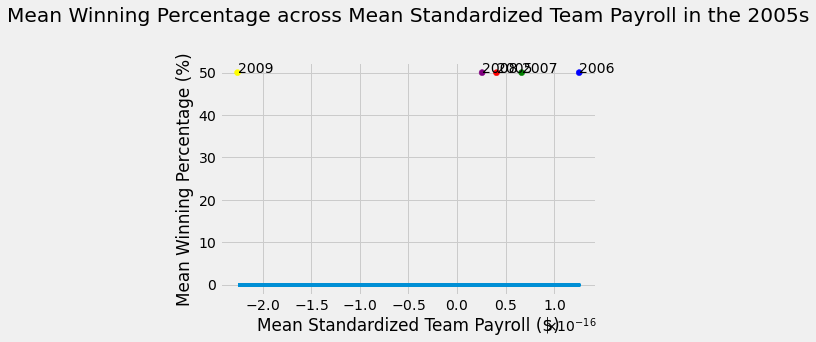

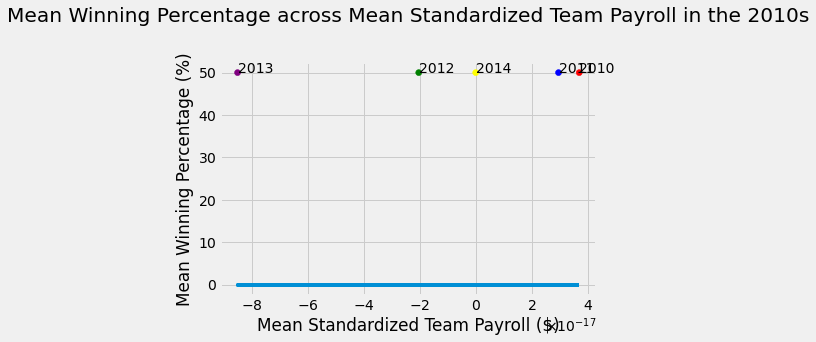

In [41]:
# obtain means
q6_df = q5_df.groupby('yearID', as_index=False).mean()

#round off those pesky decimals
q6_df["winning_percentage"] = q6_df["winning_percentage"].round(2)

# create bins the only way I know how
q6_df["half_decade"] = (q6_df["yearID"] //5 ) * 5
periods = [1990, 1995, 2000, 2005, 2010]

# Axes formatting stuff
xfmt = ScalarFormatter(useMathText = True, useOffset=False)
yfmt = ScalarFormatter(useMathText = True, useOffset=False)
colors =['red', 'blue','green','purple','yellow']

for period in periods:
    # get the slice of df for that period
    slice_df = q6_df[q6_df["half_decade"] == period]
   
    # calculate regression coeffs
    m, b = np.polyfit(slice_df["standardized_payroll"], slice_df["standardized_payroll"], 1)

    # plot points
    plt.scatter(slice_df["standardized_payroll"], slice_df["winning_percentage"], c=colors)
    # # plot regression line
    # plt.plot(slice_df["standardized_payroll"], m * slice_df["standardized_payroll"] +b)

    # Add descriptive texts
    plt.title(f"Mean Winning Percentage across Mean Standardized Team Payroll in the {period}s", pad=40)
    plt.gca().xaxis.set_major_formatter(xfmt)
    plt.gca().yaxis.set_major_formatter(yfmt)
    plt.xlabel("Mean Standardized Team Payroll ($)")
    plt.ylabel("Mean Winning Percentage (%)")

    # add annotation for each point
    for i, year in enumerate(slice_df["yearID"]):
        plt.annotate(year, (slice_df["standardized_payroll"].iloc[i], slice_df["winning_percentage"].iloc[i]))
    plt.show()

### Expected wins

It's hard to see global trends across time periods using these multiple plots, but now that we have standardized payrolls across time, we can look at a single plot showing correlation between winning percentage and payroll across time.

#### Problem 7 (8 pts)

Make a single scatter plot of winning percentage (y-axis) vs. standardized payroll (x-axis). Add a regression line to highlight the relationship.

The regression line gives you expected winning percentage as a function of standardized payroll. Looking at the regression line, it looks like teams that spend roughly the average payroll in a given year will win 50% of their games (i.e. win\_pct is 50 when standardized\_payroll is 0), and teams increase 5% wins for every 2 standard units of payroll (i.e., win\_pct is 55 when standardized\_payroll is 2). We will see how this is done in general using linear regression later in the course.

From these observations we can calculate the expected win percentage for team `i` in year `j` as

<!--
```
${expected\_win\_pct_{ij} = 50+2.5×standardized\_payroll_{ij}}$
```
-->
![](figs/prob7.png)


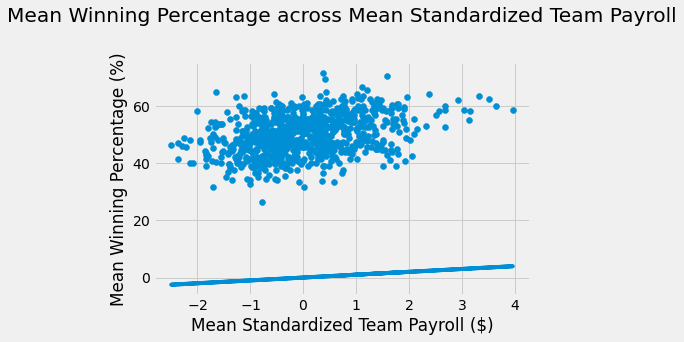

In [40]:
# Axes formatting stuff
xfmt = ScalarFormatter(useMathText = True, useOffset=False)
yfmt = ScalarFormatter(useMathText = True, useOffset=False)
colors =['red', 'blue','green','purple','yellow']
# plot points
plt.scatter(q5_df["standardized_payroll"], q5_df["winning_percentage"])
# plot regression line

m, b = np.polyfit(q5_df["standardized_payroll"], q5_df["standardized_payroll"], 1)
plt.plot(q5_df["standardized_payroll"], m* q5_df["standardized_payroll"] +b)

# Add descriptive texts
plt.title(f"Mean Winning Percentage across Mean Standardized Team Payroll", pad=40)
plt.gca().xaxis.set_major_formatter(xfmt)
plt.gca().yaxis.set_major_formatter(yfmt)
plt.xlabel("Mean Standardized Team Payroll ($)")
plt.ylabel("Mean Winning Percentage (%)")


plt.show()

<AxesSubplot:xlabel='standardized_payroll', ylabel='winning_percentage'>

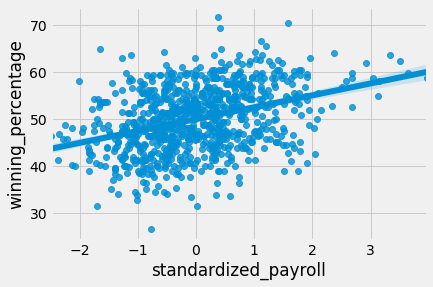

In [36]:
import seaborn as sns

#create scatterplot with regression line
sns.regplot(x=q5_df["standardized_payroll"], y=q5_df["winning_percentage"])

In [ ]:
q1_df

,yearID,teamID,total_payroll,winning_percentage
0,1985,ATL,14807000.0,40.74
1,1985,BAL,11560712.0,51.55
2,1985,BOS,10897560.0,49.69
3,1985,CAL,14427894.0,55.56
4,1985,CHA,9846178.0,52.15
...,...,...,...,...
855,2014,SLN,120693000.0,55.56
856,2014,TBA,72689100.0,47.53
857,2014,TEX,112255059.0,41.36
858,2014,TOR,109920100.0,51.23
